In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Callable, Sequence

import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import torch.optim as optim
import torchvision

In [3]:
import sys
src_path = ".."
if src_path not in sys.path:
    sys.path.append(src_path)

In [4]:
from src.diffusion_model import DiffusionUNet
import src.diffusion_schedulers as diffusion_schedulers
from src.train import train as train_model
from src.sample import ddim_sampler
from src.utils import tensor_to_pil

In [5]:
dataset_dir = "../datasets/flowers_2/"

First we will convert the image file into a tensor

In [7]:
def transforms():
    """ 
    ToTensor: 
        Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
        to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

    Resize:
        Resize the input image to the given size. 
        If the image is torch Tensor, it is expected to have […, H, W] shape
    """
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(
            (64, 64), 
            interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR
        ),
        torchvision.transforms.ToTensor(),
    ])

In [8]:
train_dataset = torchvision.datasets.Flowers102(dataset_dir, split="train", transform=transforms(), download=True)
valid_dataset = torchvision.datasets.Flowers102(dataset_dir, split="val", transform=transforms(), download=True)
test_dataset = torchvision.datasets.Flowers102(dataset_dir, split="test", transform=transforms(), download=True)

In [9]:
len(train_dataset), len(valid_dataset), len(test_dataset), 

(1020, 1020, 6149)

Text(0.5, 1.0, 'noise')

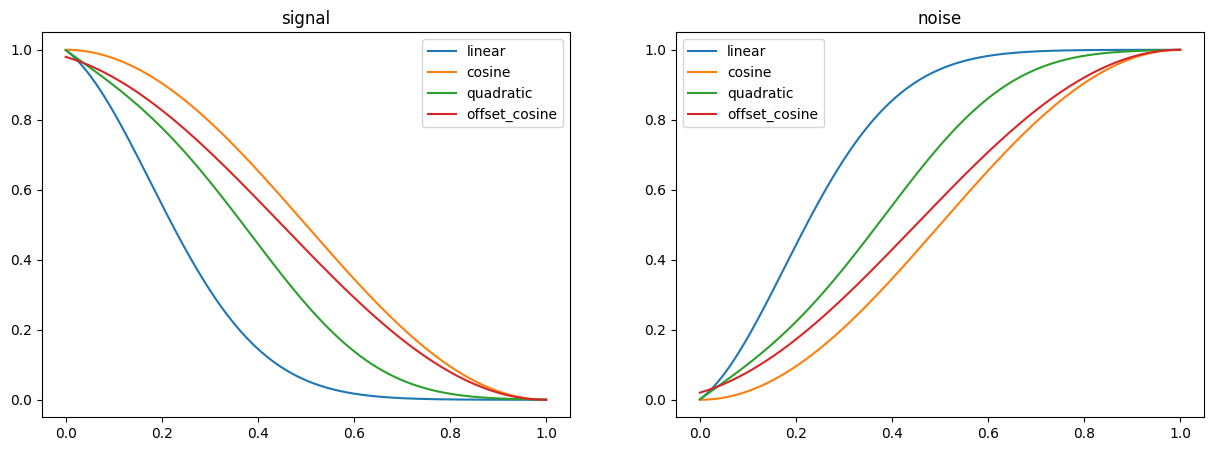

In [10]:
steps = 1000
diffusion_times = np.linspace(0.0, 1.0, steps)
linrates = diffusion_schedulers.linear(0.001, 0.02, diffusion_times)
quadratic = diffusion_schedulers.quadratic(0.001, 0.02, diffusion_times)
cosrates = diffusion_schedulers.cosine(diffusion_times, offset=0)
offset_cosine = diffusion_schedulers.cosine(diffusion_times, offset=0.1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.plot(np.linspace(0, 1, steps), linrates, label="linear")
ax1.plot(np.linspace(0, 1, steps), cosrates, label="cosine")
ax1.plot(np.linspace(0, 1, steps), quadratic, label="quadratic")
ax1.plot(np.linspace(0, 1, steps), offset_cosine, label="offset_cosine")
ax1.legend()
ax1.set_title("signal")

ax2.plot(np.linspace(0, 1, steps), 1 - linrates, label="linear")
ax2.plot(np.linspace(0, 1, steps), 1 - cosrates, label="cosine")
ax2.plot(np.linspace(0, 1, steps), 1 - quadratic, label="quadratic")
ax2.plot(np.linspace(0, 1, steps), 1 - offset_cosine, label="offset_cosine")
ax2.legend()
ax2.set_title("noise")

In [11]:
def image_corruption(
    input_image: torch.Tensor, 
    max_steps: int,
    schedule: Callable[list[float], list[float]]
) -> torch.Tensor:
    """ Returns image corrupted at different time steps """
    diffusion_times = np.linspace(0.0, 1.0, num=max_steps)
    alpha_bars = torch.Tensor(schedule(diffusion_times)).view(max_steps, 1, 1, 1)
    input_repeated = input_image.repeat((max_steps, 1, 1, 1))
    gaussian_noise = torch.randn((max_steps, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
    images = torch.sqrt(alpha_bars) * input_repeated + torch.sqrt(1 - alpha_bars) * gaussian_noise
    return torch.cat((torch.unsqueeze(input_image, 0), images))

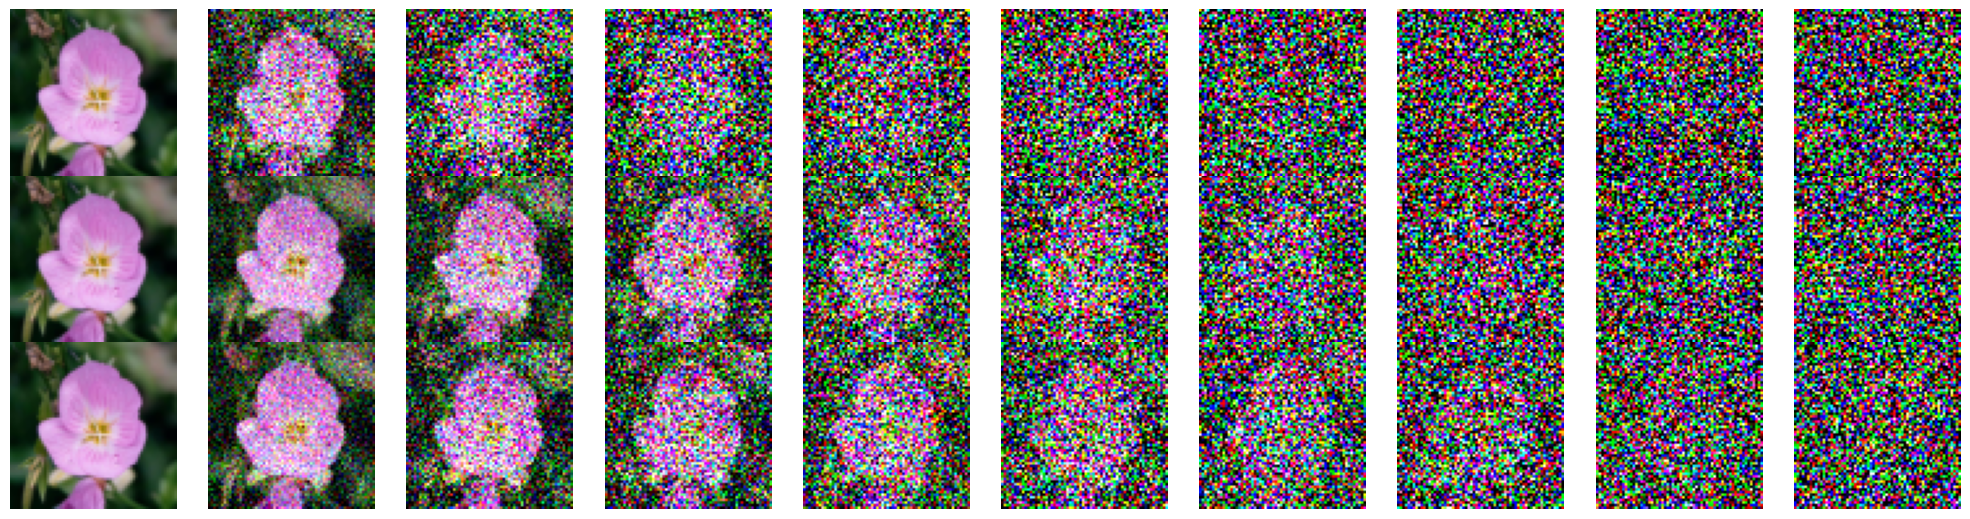

In [12]:
steps = 1000
test_batch_data = test_dataset[0]
linear_corrupted = image_corruption(test_batch_data[0], steps, lambda s: diffusion_schedulers.linear(0.0001, 0.02, s))
quadratic_corrupted = image_corruption(test_batch_data[0], steps, lambda s: diffusion_schedulers.quadratic(0.0001, 0.02, s))
cosine_corrupted = image_corruption(test_batch_data[0], steps, lambda s: diffusion_schedulers.cosine(s))
f, ax = plt.subplots(3, int(steps / 100), sharey=True, figsize=(20, 5))
for i in range(len(ax[0])):
    img = linear_corrupted[i * 100]
    ax[0][i].imshow(tensor_to_pil(img))
    ax[0][i].axis("off")

    img = quadratic_corrupted[i * 100]
    ax[1][i].imshow(tensor_to_pil(img))
    ax[1][i].axis("off")

    img = cosine_corrupted[i * 100]
    ax[2][i].imshow(tensor_to_pil(img))
    ax[2][i].axis("off")

    
f.tight_layout(pad=0, h_pad=0, w_pad=0)

# Model Definition

In [13]:
model = DiffusionUNet(
    in_channels=3,
    out_channels=3,
    base_channels=32,
    image_resolution=64,
    num_res_blocks=2,
    channel_multipliers=[1, 2, 4, 8],
    attention_resolutions=[16],
    dropout=0.1,
    resample_with_conv=True,
    time_emb_dim=128,
)   

In [14]:
model.config()

{'in_channels': 3,
 'out_channels': 3,
 'base_channels': 32,
 'image_resolution': 64,
 'num_res_blocks': 2,
 'channel_multipliers': [1, 2, 4, 8],
 'attention_resolutions': [16],
 'resample_with_conv': True,
 'time_emb_dim': 128,
 'dropout': 0.1}

In [15]:
batch_size = 4
x = torch.randn(batch_size, 3, 64, 64)
t = torch.randn((batch_size,))

print("input", x.shape, "noise shape", t.shape)
y = model(x, t)
print("output", y.shape)

input torch.Size([4, 3, 64, 64]) noise shape torch.Size([4])
output torch.Size([4, 3, 64, 64])


## Training

In [6]:
train_dataloader = torch_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = torch_data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

NameError: name 'train_dataset' is not defined

In [7]:
epochs = 10
batch_size = 4
model = DiffusionUNet(
    in_channels=3,
    out_channels=3,
    base_channels=32,
    image_resolution=64,
    num_res_blocks=2,
    channel_multipliers=[1, 2, 4, 8],
    attention_resolutions=[16],
    dropout=0.1,
    resample_with_conv=True,
    time_emb_dim=128,
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
min_rate = 0.02
max_rate = 0.95
timesteps = 1000
diffusion_times = np.linspace(0, 1, timesteps)
alpha_bars = diffusion_schedulers.cosine(diffusion_times, offset=0.008)
signal_rates = torch.tensor(np.sqrt(alpha_bars), dtype=torch.float)
noise_rates = torch.tensor(np.sqrt(1 - alpha_bars), dtype=torch.float)

In [44]:
model = model.load_weights("../data/checkpoint.pt")

In [45]:
model = train_model(
    model,
    train_dataloader, 
    optimizer, 
    signal_rates, 
    noise_rates, 
    timesteps, 
    valid_dataloader, 
    epochs=epochs, 
    batch_size=batch_size, 
    checkpoint_path="../data/checkpoint.pt"
)

100%|███████████████████████████████████████████████████| 255/255 [01:56<00:00,  2.19it/s]


Epoch 0: Average Loss 0.03671


100%|███████████████████████████████████████████████████| 255/255 [00:40<00:00,  6.35it/s]


Validation Loss: 0.03569
Saving checkpoint for epoch 1...
New best validation loss: 0.03569
Saving best model to ../data/checkpoint.pt...


100%|███████████████████████████████████████████████████| 255/255 [01:48<00:00,  2.36it/s]


Epoch 1: Average Loss 0.03480


100%|███████████████████████████████████████████████████| 255/255 [00:33<00:00,  7.58it/s]


Validation Loss: 0.04165
Saving checkpoint for epoch 2...


100%|███████████████████████████████████████████████████| 255/255 [01:42<00:00,  2.48it/s]


Epoch 2: Average Loss 0.03947


100%|███████████████████████████████████████████████████| 255/255 [00:34<00:00,  7.43it/s]


Validation Loss: 0.03864
Saving checkpoint for epoch 3...


100%|███████████████████████████████████████████████████| 255/255 [01:44<00:00,  2.45it/s]


Epoch 3: Average Loss 0.03883


100%|███████████████████████████████████████████████████| 255/255 [00:32<00:00,  7.95it/s]


Validation Loss: 0.03406
Saving checkpoint for epoch 4...
New best validation loss: 0.03406
Saving best model to ../data/checkpoint.pt...


100%|███████████████████████████████████████████████████| 255/255 [01:43<00:00,  2.46it/s]


Epoch 4: Average Loss 0.04064


100%|███████████████████████████████████████████████████| 255/255 [00:32<00:00,  7.80it/s]


Validation Loss: 0.04053
Saving checkpoint for epoch 5...


100%|███████████████████████████████████████████████████| 255/255 [01:44<00:00,  2.45it/s]


Epoch 5: Average Loss 0.04000


100%|███████████████████████████████████████████████████| 255/255 [00:32<00:00,  7.91it/s]


Validation Loss: 0.04051
Saving checkpoint for epoch 6...


100%|███████████████████████████████████████████████████| 255/255 [01:42<00:00,  2.49it/s]


Epoch 6: Average Loss 0.03954


100%|███████████████████████████████████████████████████| 255/255 [00:34<00:00,  7.35it/s]


Validation Loss: 0.04011
Saving checkpoint for epoch 7...


100%|███████████████████████████████████████████████████| 255/255 [01:42<00:00,  2.49it/s]


Epoch 7: Average Loss 0.03685


100%|███████████████████████████████████████████████████| 255/255 [00:32<00:00,  7.93it/s]


Validation Loss: 0.03723
Saving checkpoint for epoch 8...


100%|███████████████████████████████████████████████████| 255/255 [01:41<00:00,  2.52it/s]


Epoch 8: Average Loss 0.03967


100%|███████████████████████████████████████████████████| 255/255 [00:32<00:00,  7.79it/s]


Validation Loss: 0.03670
Saving checkpoint for epoch 9...


100%|███████████████████████████████████████████████████| 255/255 [01:42<00:00,  2.48it/s]


Epoch 9: Average Loss 0.04195


100%|███████████████████████████████████████████████████| 255/255 [00:31<00:00,  8.16it/s]

Validation Loss: 0.03477
Saving checkpoint for epoch 10...


In [8]:
best_model = DiffusionUNet(
    in_channels=3,
    out_channels=3,
    base_channels=32,
    image_resolution=64,
    num_res_blocks=2,
    channel_multipliers=[1, 2, 4, 8],
    attention_resolutions=[16],
    dropout=0.1,
    resample_with_conv=True,
    time_emb_dim=128,
)
best_model.load_state_dict(torch.load("../data/checkpoint.pt"))

<All keys matched successfully>

In [11]:
sampled_image = ddim_sampler(
    best_model, 
    noise_rates, 
    signal_rates, 
    timesteps,
    step_size=20, 
    batch_size=2
)

Sampling: 2it [00:00, 14.81it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 6it [00:00, 15.06it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 10it [00:00, 15.39it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 14it [00:00, 15.14it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 16it [00:01, 15.00it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 20it [00:01, 14.62it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 22it [00:01, 14.41it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 26it [00:01, 14.74it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 30it [00:02, 14.65it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 32it [00:02, 14.55it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 36it [00:02, 14.21it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 38it [00:02, 14.46it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 42it [00:02, 14.44it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 44it [00:02, 14.48it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 48it [00:03, 14.49it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])


Sampling: 50it [00:03, 14.67it/s]

torch.Size([2, 1, 1, 1]) torch.Size([2, 1, 1, 1]) torch.Size([2])
Final step, no noise added


In [13]:
sampled_image.shape

torch.Size([2, 3, 64, 64])

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

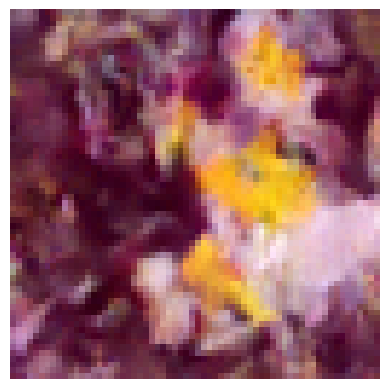

In [14]:
plt.figure()
img = sampled_image[0].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')

In [ ]:
plt.figure()
img = sampled_image[1][0].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')